In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import toynet
from eval_utils import *
from utils import stack_imgs, dotdict
from losses import AdaptiveLoss, get_q

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

import pandas as pd
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [27]:
device = torch.device('cuda')

config = dotdict()
config.model = dotdict()
config.model.objective = 'am'
config.model.sigma = 'simple'
config.model.task = 'diffusion'
config.model.classification = False
config.data = dotdict()
config.data.num_channels, config.data.image_size, config.data.image_size = 1,1,1
config.data.ydim = 0

q_t, w, dwdt = get_q(config)

data_samples = 1000
data = torch.randn([3*data_samples,1])
data = torch.vstack([data, torch.randn([data_samples,1]) + 5])
data = torch.vstack([data, torch.randn([data_samples//2,1]) - 3])
data = torch.vstack([data, torch.randn([4*data_samples,1]) + 12])
data = data/data.std()
data = data.to(device)
data += 5

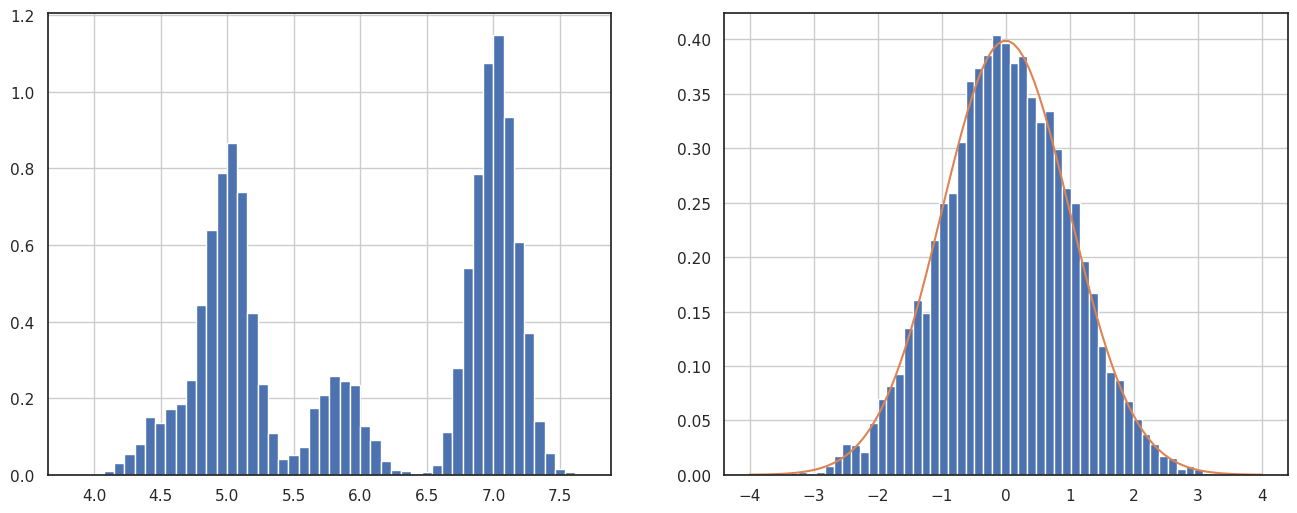

In [28]:
figsize(16,6)
plt.subplot(121)
plt.hist(data.cpu().numpy(), bins=50, density=True)
plt.grid()

x_1, _ = q_t(data, torch.ones([data.shape[0],1]).to(device))
plt.subplot(122)
plt.hist(x_1.cpu().numpy(), bins=50, density=True)
x = np.linspace(-4,4,100)
plt.plot(x, np.exp(-0.5*x**2)/math.sqrt(2*math.pi))
plt.grid()

# plt.subplot(133)
# eps = 1e-3
# plt.plot(alpha(torch.linspace(eps,1-eps,100)))
# plt.plot(sigma(torch.linspace(eps,1-eps,100)))
# plt.plot(alpha(torch.linspace(eps,1-eps,100))**2 + sigma(torch.linspace(eps,1-eps,100))**2)
# plt.grid()

In [31]:
df_dict = {'x': None, 'g': None}
for t in np.linspace(0.0, 1.0, 11):
    times = t*torch.ones([data.shape[0],1]).to(device)
    x_t = data + 5*t
    if df_dict['x'] is not None:
        df_dict['x'] = np.concatenate([df_dict['x'], x_t.cpu().numpy().flatten()])
        df_dict['g'] = np.concatenate([df_dict['g'], times.cpu().numpy().flatten()])
    else:    
        df_dict['x'] = x_t.cpu().numpy().flatten()
        df_dict['g'] = times.cpu().numpy().flatten()
df = pd.DataFrame(df_dict)

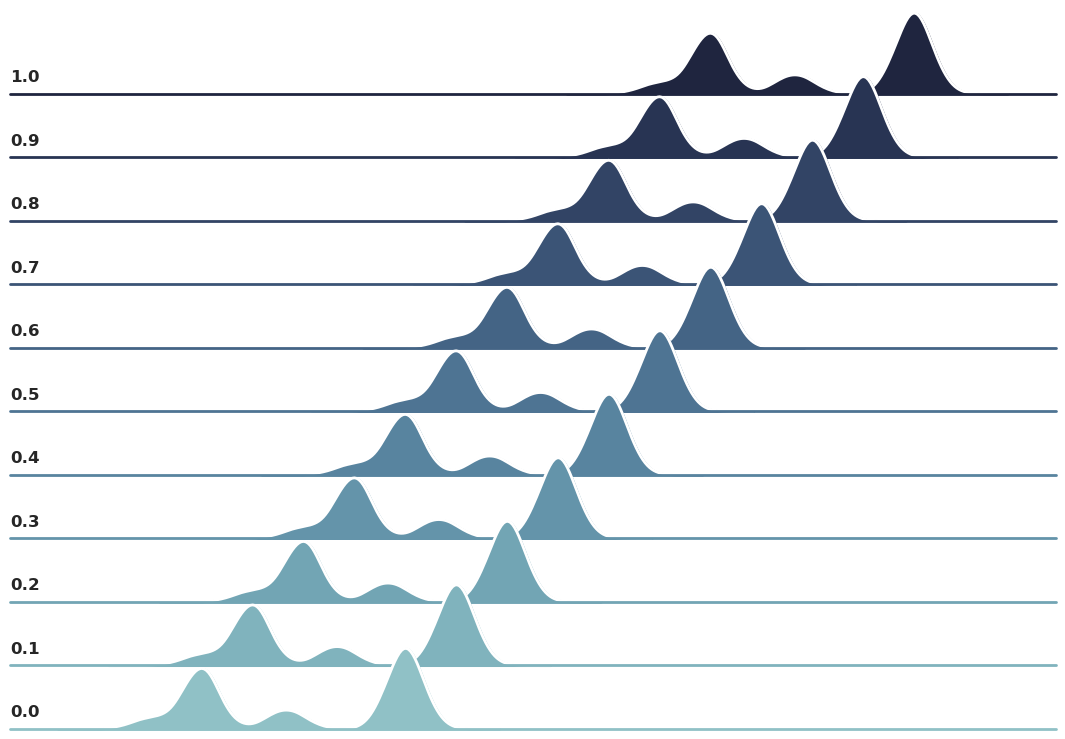

In [32]:


# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(11, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.75, palette=pal, row_order=np.linspace(0.0, 1.0, 11)[::-1])

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=0.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=0.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, f'{label}', fontweight="bold", #color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="", xticks=[])
g.despine(bottom=True, left=True)
plt.savefig('amvssm.png', bbox_inches='tight')
plt.show()

In [5]:
df_dict = {'x': None, 'g': None}
for t in np.linspace(0.0, 1.0, 11):
    times = t*torch.ones([data.shape[0],1]).to(device)
    x_t, _ = q_t(data, times)
    if df_dict['x'] is not None:
        df_dict['x'] = np.concatenate([df_dict['x'], x_t.cpu().numpy().flatten()])
        df_dict['g'] = np.concatenate([df_dict['g'], times.cpu().numpy().flatten()])
    else:    
        df_dict['x'] = x_t.cpu().numpy().flatten()
        df_dict['g'] = times.cpu().numpy().flatten()
df = pd.DataFrame(df_dict)

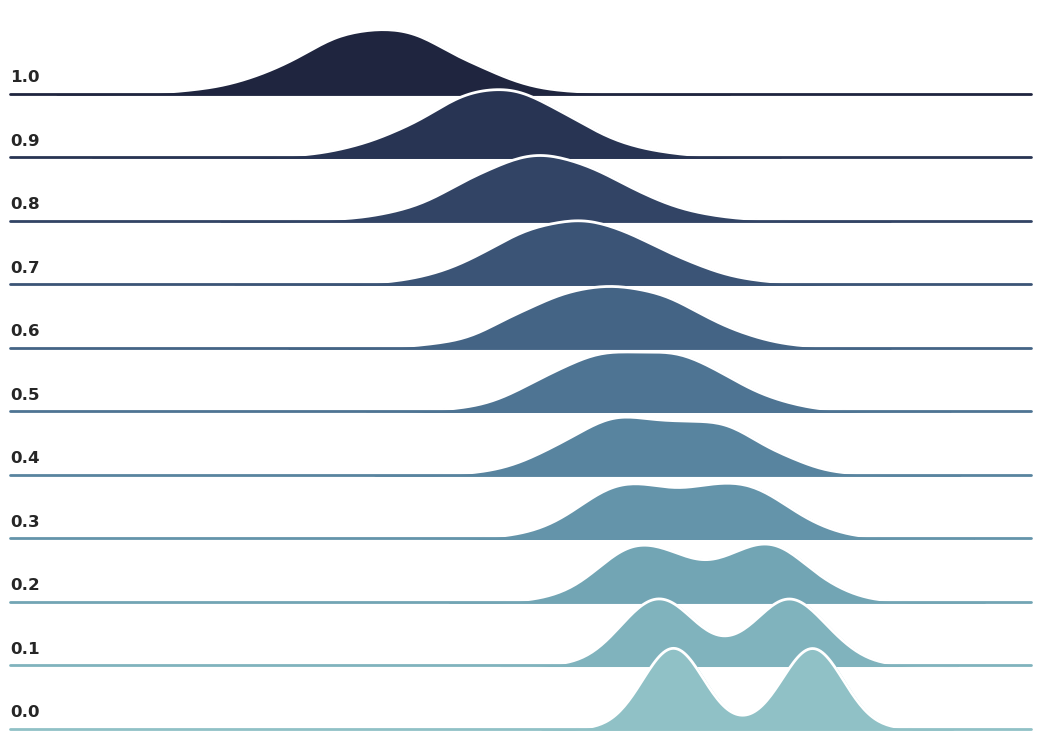

In [6]:


# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(11, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.75, palette=pal, row_order=np.linspace(0.0, 1.0, 11)[::-1])

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=1.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=1.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, f'{label}', fontweight="bold", #color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="", xticks=[])
g.despine(bottom=True, left=True)
plt.savefig('amvssm.png', bbox_inches='tight')
plt.show()